In [11]:
# remove futurewarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [12]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from qdax_es.utils.count_plots import plot_archive_value
from qdax_es.core.containers.count_repertoire import CountMapElitesRepertoire

In [13]:
from qdax_es.utils.gaussian_process import GPState, train_gp, gp_predict, gp_batch_predict

In [14]:
from jax.config import config
# jax.config.update("jax_enable_x64", True)

# config.update("jax_debug_nans", True)

In [15]:
num_centroids = 1000

# Bounds
minval, maxval = -1, 1

# Generate random centroids
random_key = jax.random.PRNGKey(0)
centroids = jax.random.uniform(random_key, (num_centroids, 2), minval=minval, maxval=maxval)

In [16]:
@jit
def f(x):
    return jnp.sin(x[0] + x[1])

count = jax.random.choice(random_key, jnp.arange(2), shape=(num_centroids,))
# count = jnp.ones(num_centroids)
# Put fitness if count > 0
mask = count > 0
fitnesses = jnp.where(mask, f(centroids.T), -jnp.inf)
descriptors = centroids
mask.sum()

Array(498, dtype=int64)

In [17]:
%matplotlib inline

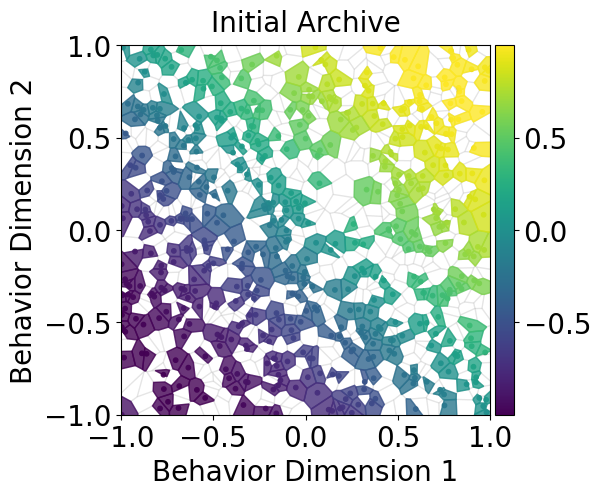

In [18]:
repertoire = CountMapElitesRepertoire(
    genotypes=None, 
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    count=count,
)
plot_archive_value(
    repertoire=repertoire,
    y= fitnesses,
    title="Initial Archive",
    minval=minval,
    maxval=maxval,
)

%matplotlib inline

plt.show()

In [19]:
gp_state = GPState.init(
    x=centroids,
    y=fitnesses,
    weighted=False,
    count=count,
    empty_weight=1,
)

Valid params: 47
100 RBFParams(sigma=Array(0.11135774, dtype=float64), lengthscale=Array(0.29696207, dtype=float64), obs_noise_sigma=Array(0.99083153, dtype=float64))
Mean: -0.616809000463725 - 0.6087069060957616


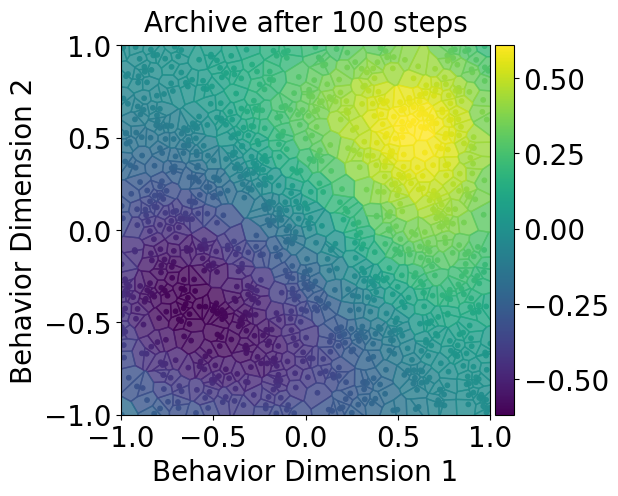

In [20]:
# Run the training loop with scan
steps = [1, 10, 100, 1000]
steps = [100]

for num_steps in steps:
    with jax.disable_jit():
        fit_gp_state = train_gp(gp_state, num_steps=num_steps)
    print(num_steps, fit_gp_state.kernel_params)
    mean, var = gp_batch_predict(fit_gp_state, centroids)
    print(f"Mean: {mean.min()} - {mean.max()}")
    plot_archive_value(
        repertoire=repertoire,
        y=mean,
        title=f"Archive after {num_steps} steps",
        minval=minval,
        maxval=maxval,
    )
    plt.show()

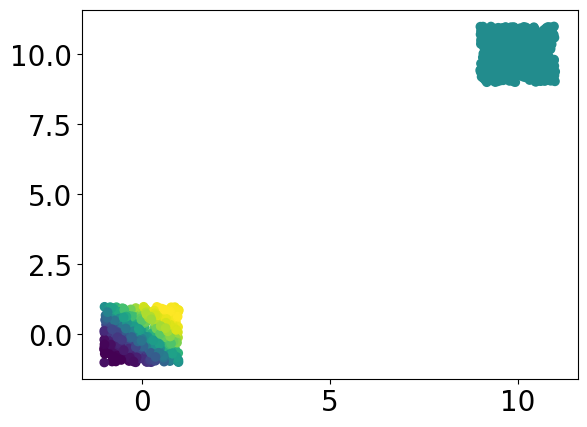

In [21]:
plt.scatter(fit_gp_state.x[:, 0], fit_gp_state.x[:, 1], c=fit_gp_state.y)

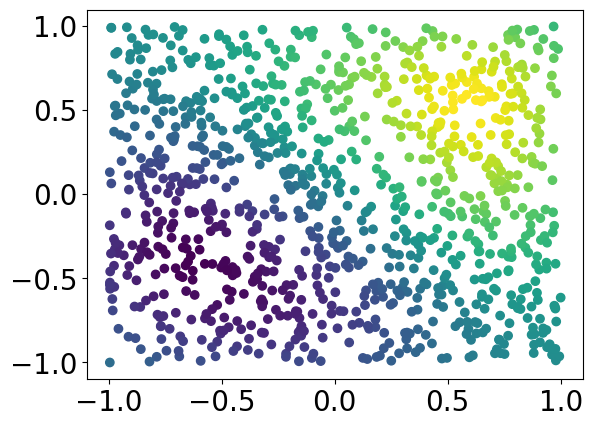

In [30]:
mean, var = gp_batch_predict(fit_gp_state, centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c=mean)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'True fitness'}, xlabel='Behavior Dimension 1', ylabel='Behavior Dimension 2'>)

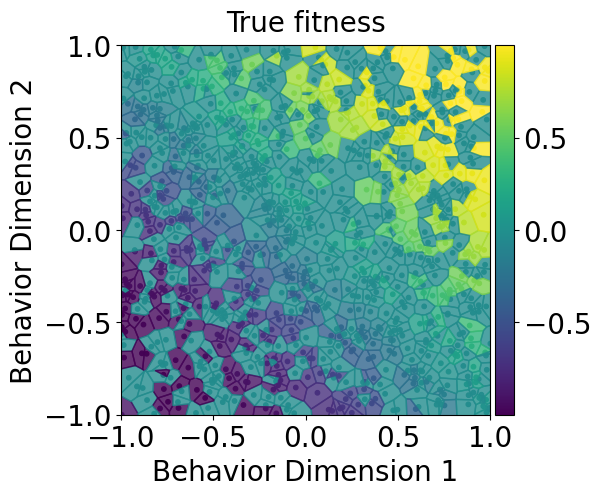

In [31]:
plot_archive_value(
    repertoire=repertoire,
    y=gp_state.y,
    title="True fitness",
    minval=minval,
    maxval=maxval,
)

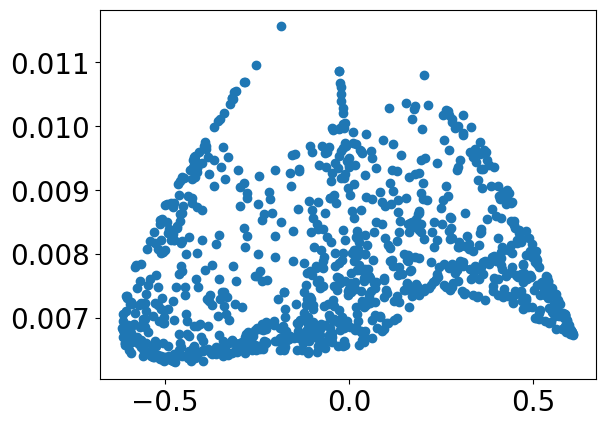

In [32]:
plt.scatter(mean, var)

In [33]:
import importlib
pareto_mod = importlib.import_module("qdax_es.utils.pareto_selection")
pareto_mod = importlib.reload(pareto_mod)

pareto_front = pareto_mod.pareto_front

In [36]:
def pareto_filter(f1, f2):
    def is_dominated(x):
        """Check if a point is dominated."""
        return jnp.any((f1 > x[0]) & (f2 > x[1]))

    # zip f1 and f2
    f = jnp.vstack([f1, f2]).T
    dominated = jax.vmap(is_dominated)(f)
    return ~ dominated

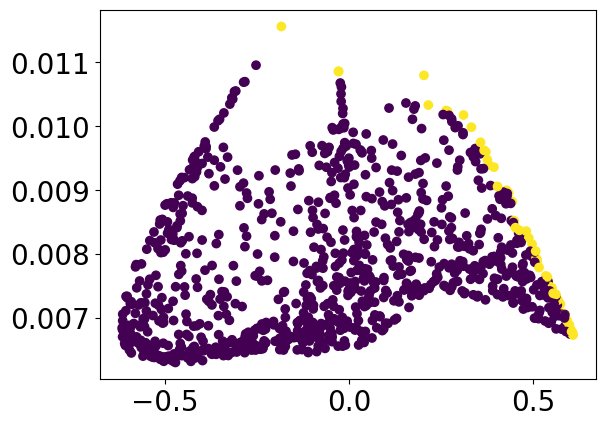

In [37]:
f = pareto_filter(mean, var)
plt.scatter(mean, var, c=f)

In [43]:
num_points = 60

indices = jnp.arange(num_centroids)
# proba
p = f / f.sum()
# select
selected = jax.random.choice(
    random_key, 
    indices, 
    shape=(num_points,), 
    p=p, 
    replace=False
    )
selected

Array([437, 931,  88, 422, 955, 547, 500, 245, 911, 994, 339, 816, 626,
       108, 626, 547, 495, 122, 942, 506, 816, 339, 339, 975, 626, 931,
       952, 108,  86, 881, 794, 427, 388, 422, 422, 587, 527, 498, 531,
       452, 194, 624, 122, 245,  51, 388, 963, 108, 952, 952, 994, 624,
       697, 388, 659, 427, 194, 803, 295, 122], dtype=int64)

In [41]:
for i in selected:
    print(i in indices[f])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
